# Úvod

# Načtení všech knihoven

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from sklearn.preprocessing import RobustScaler, MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import torchsummary
import torchinfo

pd.options.mode.chained_assignment = None

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU:', torch.cuda.get_device_name())
else:
    device = torch.device('cpu')
    print('Device:', device)

GPU: NVIDIA GeForce RTX 2070


# Načtení dat a první pohled

In [3]:
df = pd.read_csv("datasets/daily_climate/DailyDelhiClimateTrain.csv", parse_dates=["date"], index_col="date")
df.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
meantemp,1462.0,25.495521,7.348103,6.000000,18.857143,27.714286,31.305804,38.714286
humidity,1462.0,60.771702,16.769652,13.428571,50.375000,62.625000,72.218750,100.000000
wind_speed,1462.0,6.802209,4.561602,0.000000,3.475000,6.221667,9.238235,42.220000
meanpressure,1462.0,1011.104548,180.231668,-3.041667,1001.580357,1008.563492,1014.944901,7679.333333


## Nové atributy pro explorativní analýzu

In [5]:
df["year"] = df.index.year
df["month"] = df.index.month
df["day"] = df.index.day
df["day_of_week"] = df.index.dayofweek
df["date"] = df.index.date

df.head()

,meantemp,humidity,wind_speed,meanpressure,year,month,day,day_of_week,date
date,,,,,,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667,2013,1,1,1,2013-01-01
2013-01-02,7.400000,92.000000,2.980000,1017.800000,2013,1,2,2,2013-01-02
2013-01-03,7.166667,87.000000,4.633333,1018.666667,2013,1,3,3,2013-01-03
2013-01-04,8.666667,71.333333,1.233333,1017.166667,2013,1,4,4,2013-01-04
2013-01-05,6.000000,86.833333,3.700000,1016.500000,2013,1,5,5,2013-01-05


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1462 non-null   float64
 1   humidity      1462 non-null   float64
 2   wind_speed    1462 non-null   float64
 3   meanpressure  1462 non-null   float64
 4   year          1462 non-null   int32  
 5   month         1462 non-null   int32  
 6   day           1462 non-null   int32  
 7   day_of_week   1462 non-null   int32  
 8   date          1462 non-null   object 
dtypes: float64(4), int32(4), object(1)
memory usage: 91.4+ KB


# Vizualizace

## Vizualizace jednotlivých důležitých atributů

In [7]:
def plot_feature(df, feature):
    plt.figure(figsize=(15, 6))
    plt.plot(df.index, df[feature])
    plt.xlabel("Date")
    plt.ylabel(feature)
    plt.title(f"{feature} over Dates")
    plt.show()

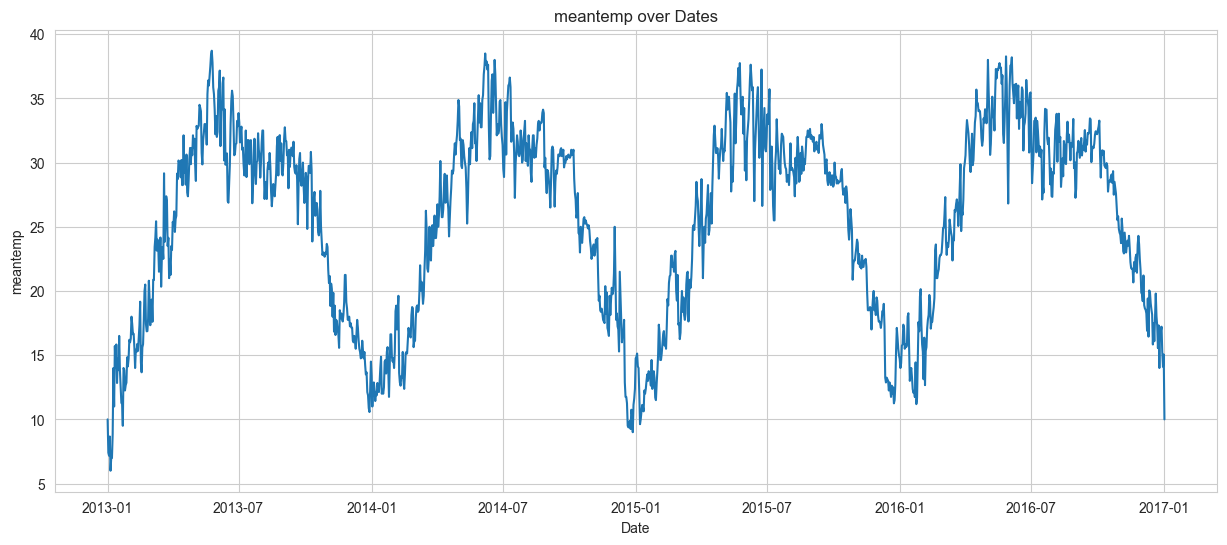

In [8]:
plot_feature(df, "meantemp")

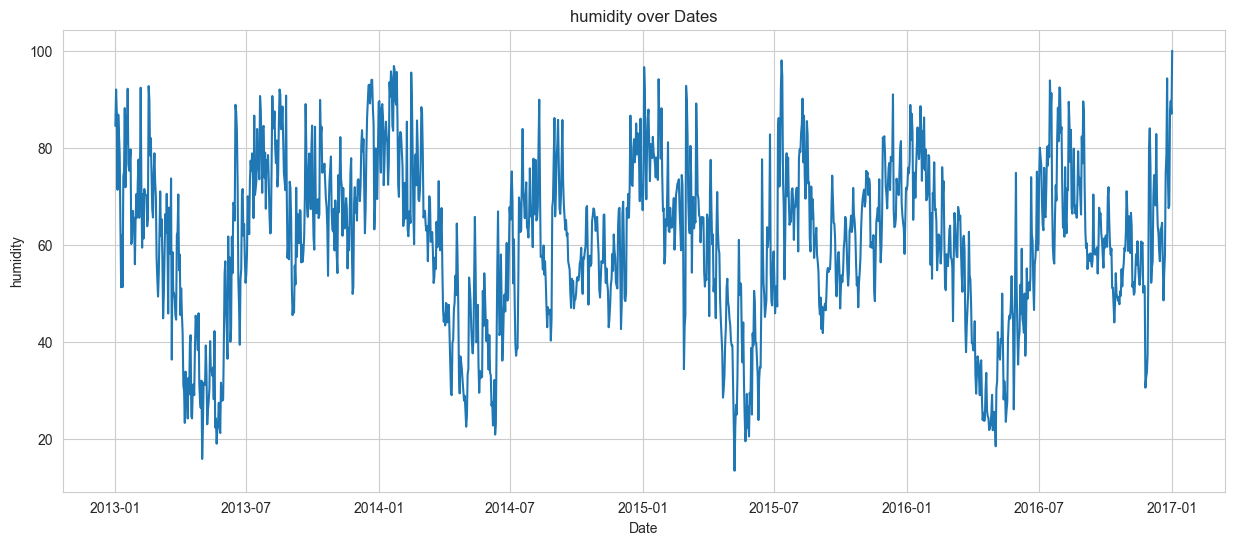

In [9]:
plot_feature(df, "humidity")

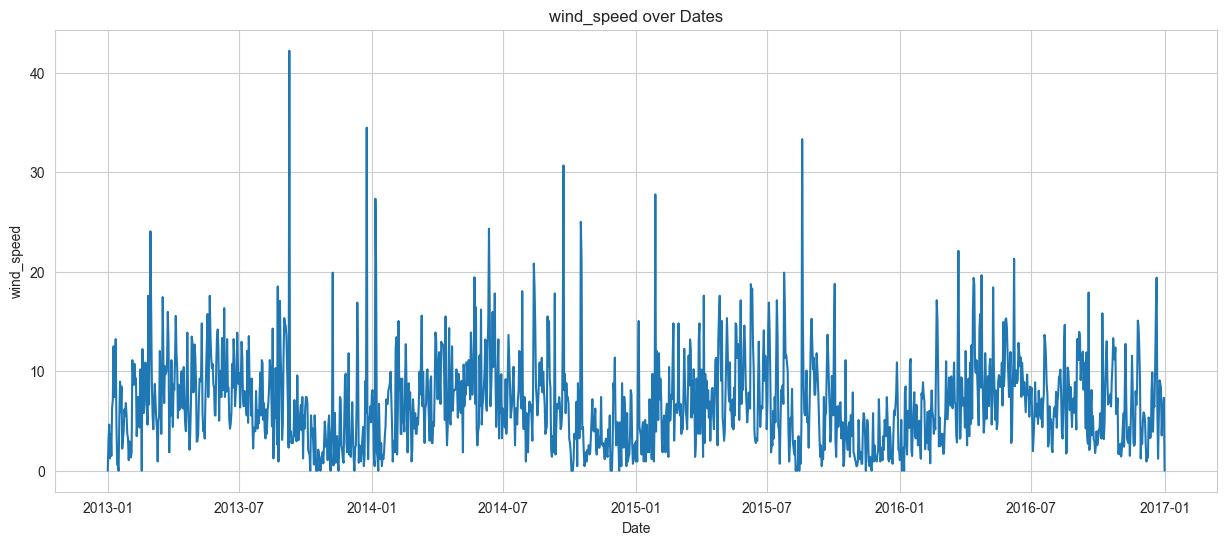

In [10]:
plot_feature(df, "wind_speed")

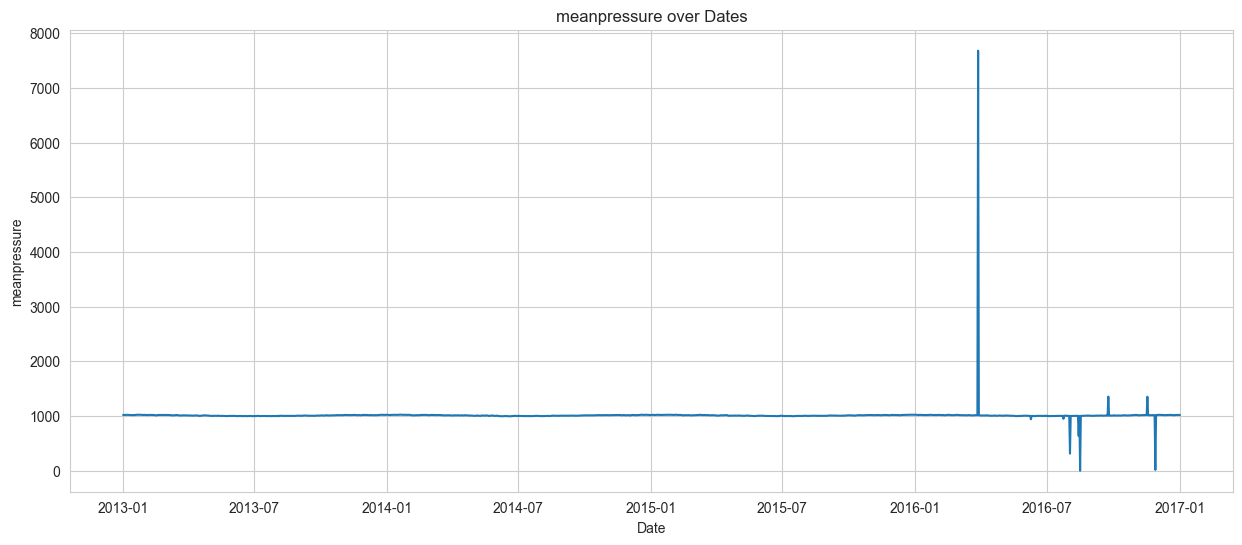

In [11]:
plot_feature(df, "meanpressure")

## Dekompozice časové řady

In [12]:
result = seasonal_decompose(df['meantemp'], model='additive', period=365)

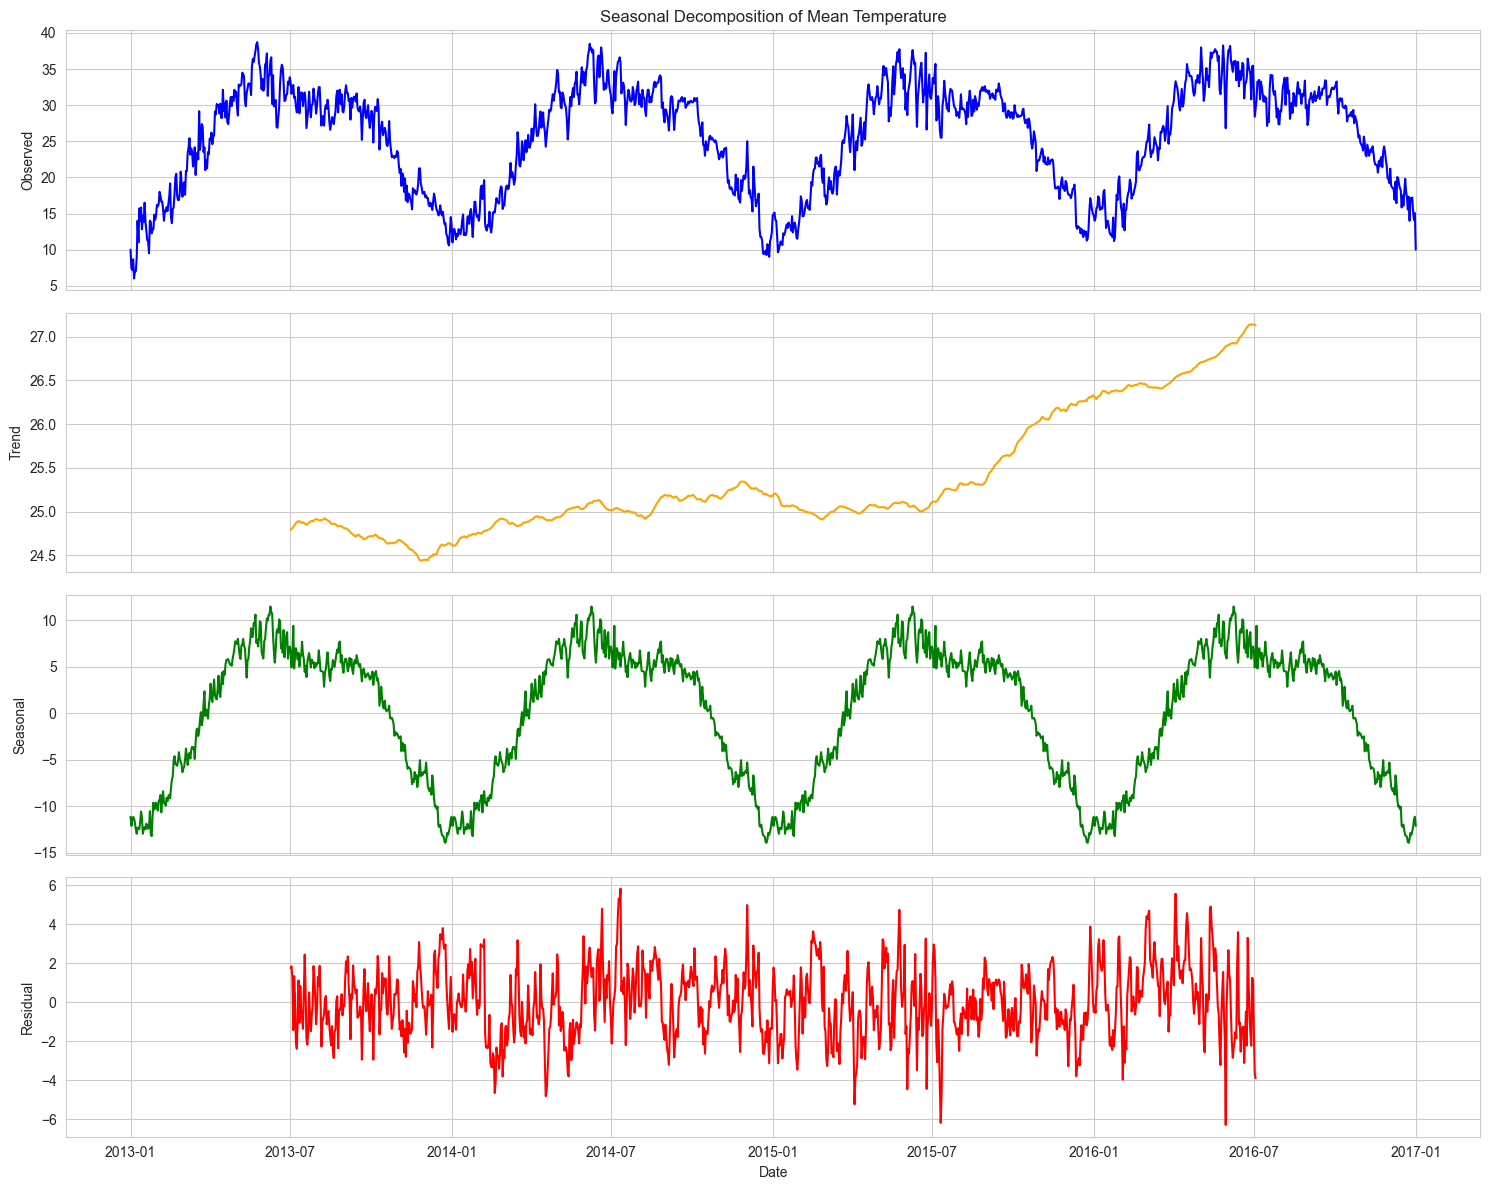

In [13]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12), sharex=True)

ax1.plot(result.observed, color='blue')
ax1.set_ylabel('Observed')
ax1.set_title('Seasonal Decomposition of Mean Temperature')

ax2.plot(result.trend, color='orange')
ax2.set_ylabel('Trend')

ax3.plot(result.seasonal, color='green')
ax3.set_ylabel('Seasonal')

ax4.plot(result.resid, color='red')
ax4.set_ylabel('Residual')
ax4.set_xlabel('Date')

plt.tight_layout()
plt.show()

## Distribuce důležitých atributů přes rok

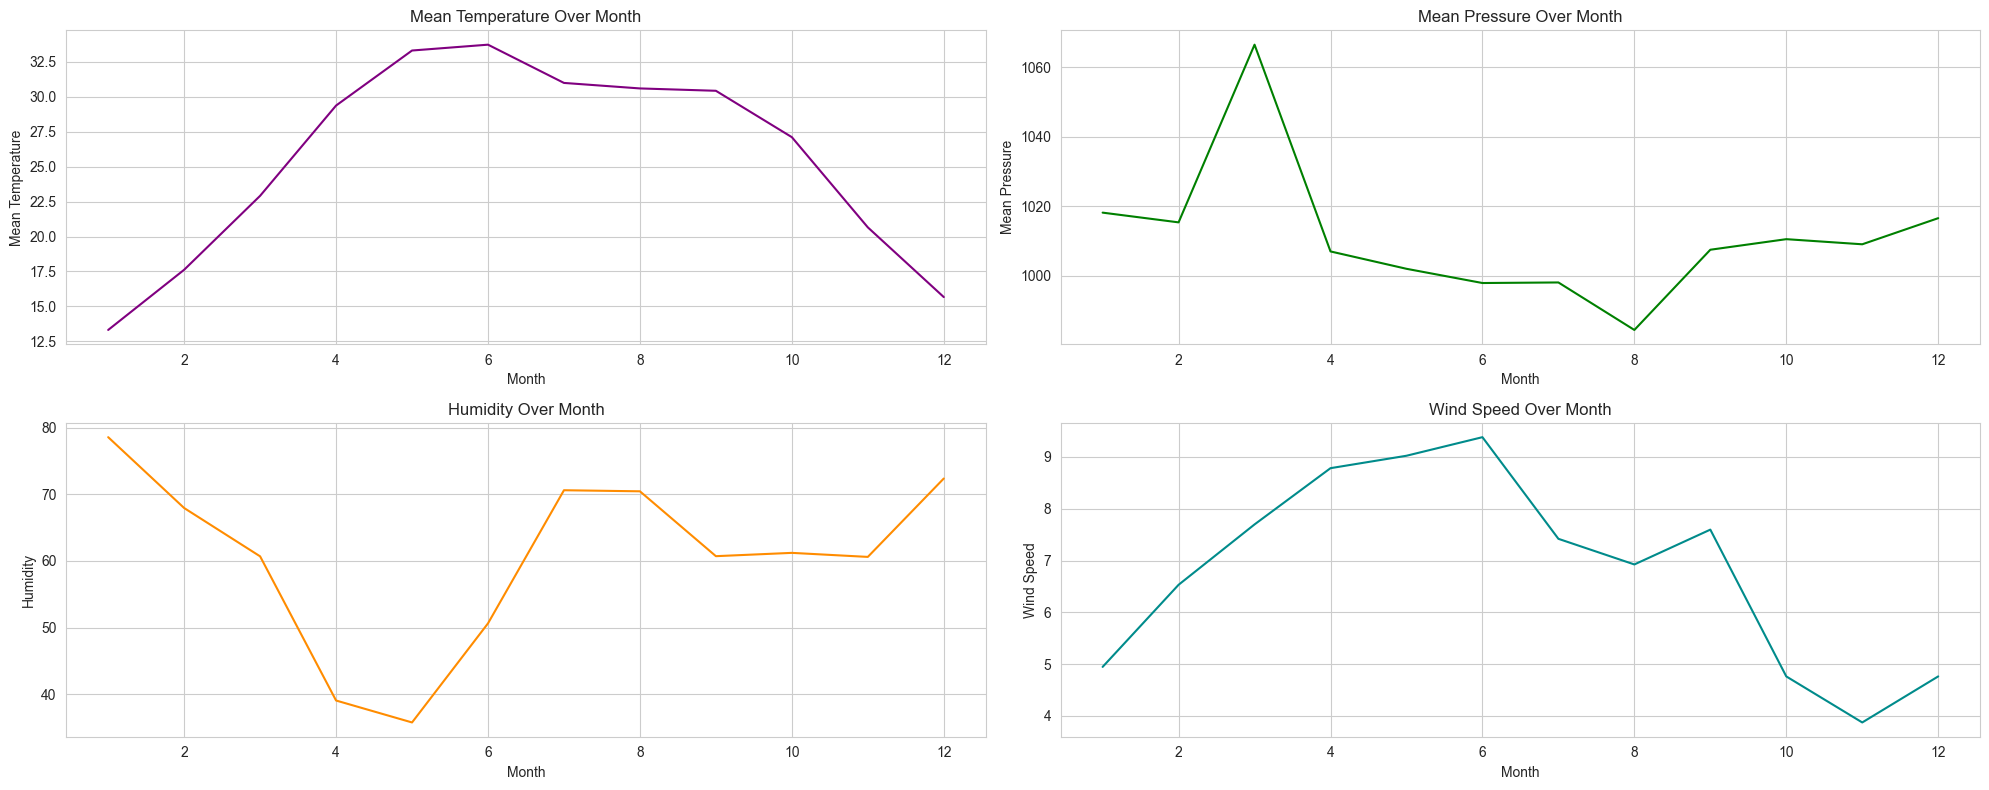

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 8))

df.groupby('month')['meantemp'].mean().plot(ax=axes[0][0], color='purple')
axes[0][0].set_title('Mean Temperature Over Month')
axes[0][0].set_xlabel('Month')
axes[0][0].set_ylabel('Mean Temperature')

df.groupby('month')['humidity'].mean().plot(ax=axes[1][0], color='darkorange')
axes[1][0].set_title('Humidity Over Month')
axes[1][0].set_xlabel('Month')
axes[1][0].set_ylabel('Humidity')

df.groupby('month')['meanpressure'].mean().plot(ax=axes[0][1], color='green')
axes[0][1].set_title('Mean Pressure Over Month')
axes[0][1].set_xlabel('Month')
axes[0][1].set_ylabel('Mean Pressure')

df.groupby('month')['wind_speed'].mean().plot(ax=axes[1][1], color='darkcyan')
axes[1][1].set_title('Wind Speed Over Month')
axes[1][1].set_xlabel('Month')
axes[1][1].set_ylabel('Wind Speed')

plt.tight_layout()
plt.show()

## Distribuce důležitých atributů přes měsíce podle roku

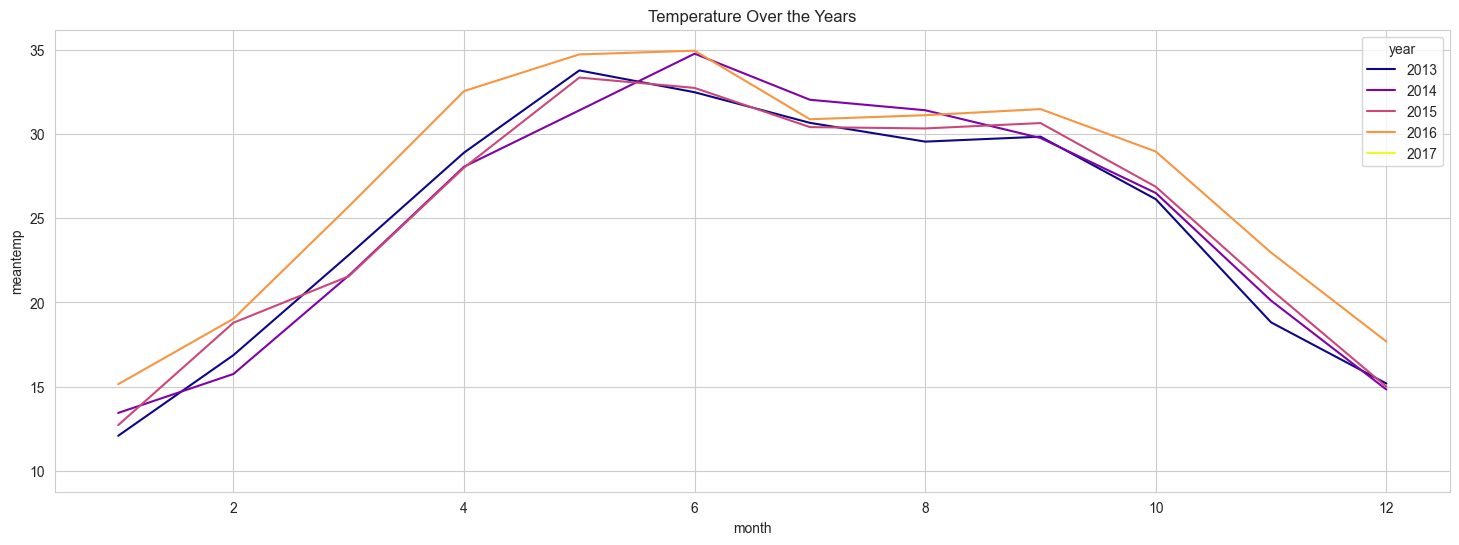

In [15]:
# Create a figure with the specified size
plt.figure(figsize=(18, 6))

plt.title("Temperature Over the Years")
sns.lineplot(data=df, x='month', y='meantemp', hue='year', palette='plasma', errorbar=None);

## Korelace

### Korelace mezi atributy

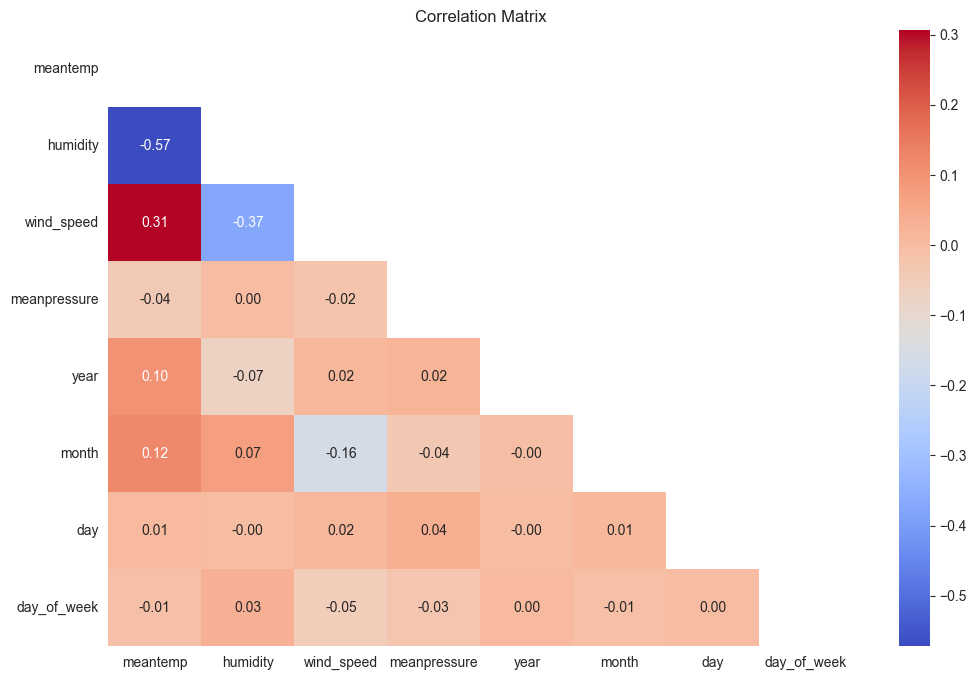

In [16]:
numeric_df = df.select_dtypes(include=['number'])
mask = np.triu(numeric_df.corr())

plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, fmt='.2f', mask=mask, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.grid(False)
plt.show()

### Korelace mezi atributy a cílovým atributem

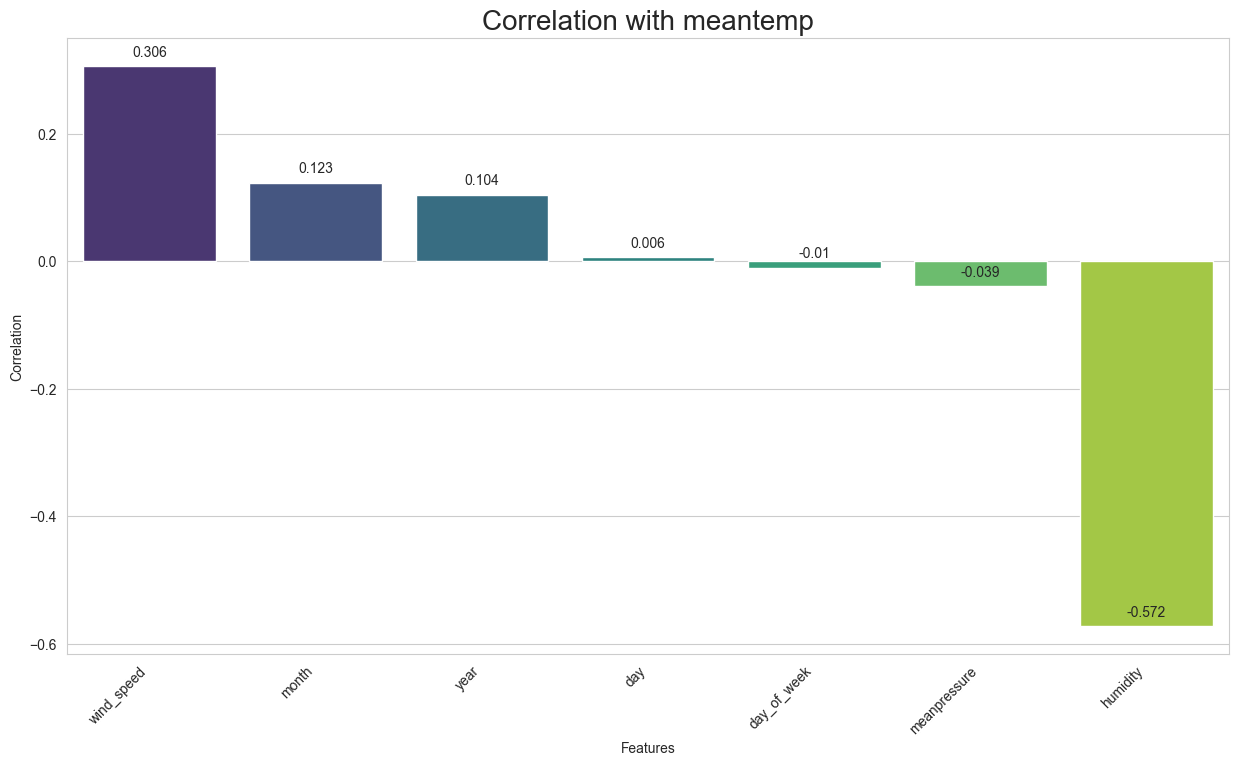

In [17]:
plt.figure(figsize=(15, 8))

correlation_matrix = round(df.select_dtypes('number').corr(), 3)
correlation_with_trgt = correlation_matrix['meantemp'].drop('meantemp').sort_values(ascending=False)

ax = sns.barplot(x=correlation_with_trgt.index, y=correlation_with_trgt.values, palette='viridis',
                 hue=correlation_with_trgt.index)

plt.title('Correlation with meantemp', size=20)
plt.xlabel('Features')
plt.ylabel('Correlation')

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.xticks(rotation=45, ha='right')
plt.show()

## Měsíční distribuce jednotlivých atributů

In [18]:
def plot_monthly_distribution(feature):
    plt.figure(figsize=(20, 10))
    df.boxplot(column=feature, by='month', grid=False)
    plt.title(f'Monthly Distribution of {feature}')
    plt.suptitle('')
    plt.xlabel('Month')
    plt.ylabel(feature)
    plt.show()

### Meantemp

<Figure size 2000x1000 with 0 Axes>

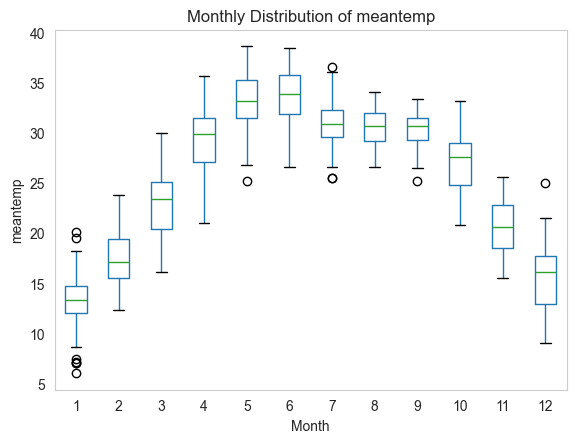

In [19]:
plot_monthly_distribution('meantemp')

### Humidity

<Figure size 2000x1000 with 0 Axes>

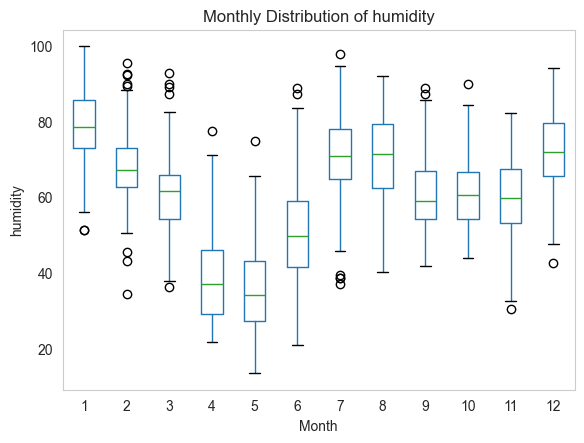

In [20]:
plot_monthly_distribution("humidity")

### Wind Speed

<Figure size 2000x1000 with 0 Axes>

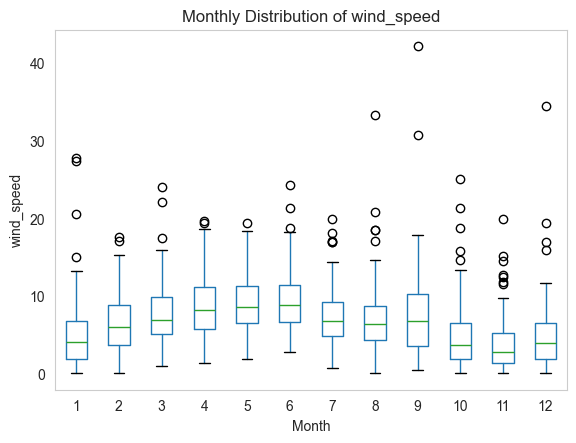

In [21]:
plot_monthly_distribution("wind_speed")

### Mean Pressure

<Figure size 2000x1000 with 0 Axes>

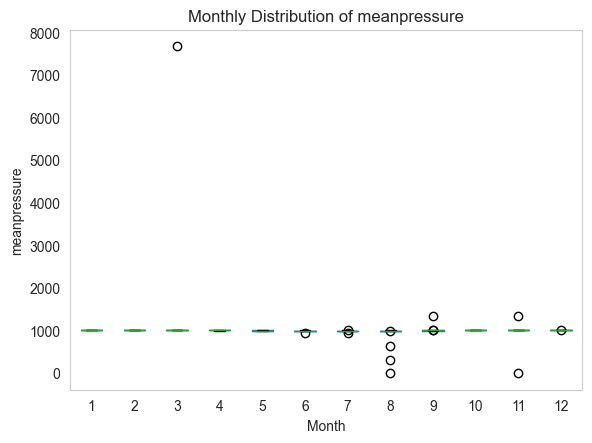

In [22]:
plot_monthly_distribution("meanpressure")

## Denní distribuce jednotlivých atributů

In [23]:
def plot_daily_distribution(feature):
    plt.figure(figsize=(20, 10))
    df.boxplot(column=feature, by='day_of_week', grid=False)
    plt.title(f'Daily Distribution of {feature}')
    plt.suptitle('')
    plt.xlabel('Day of Week')
    plt.ylabel(feature)
    plt.show()

### Meantemp

<Figure size 2000x1000 with 0 Axes>

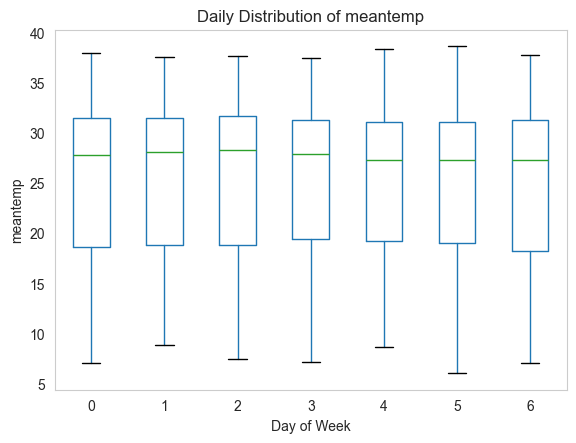

In [24]:
plot_daily_distribution("meantemp")

### Humidity

<Figure size 2000x1000 with 0 Axes>

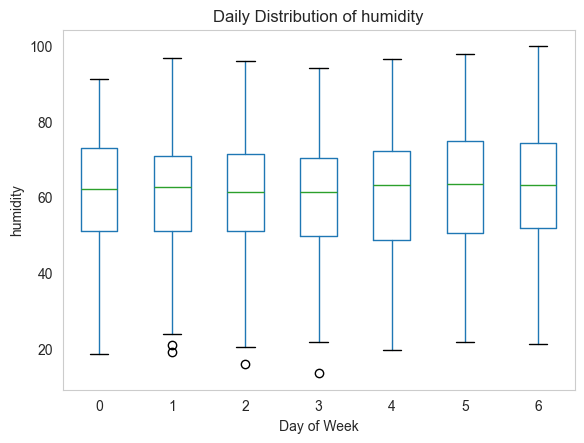

In [25]:
plot_daily_distribution("humidity")

### Wind Speed

<Figure size 2000x1000 with 0 Axes>

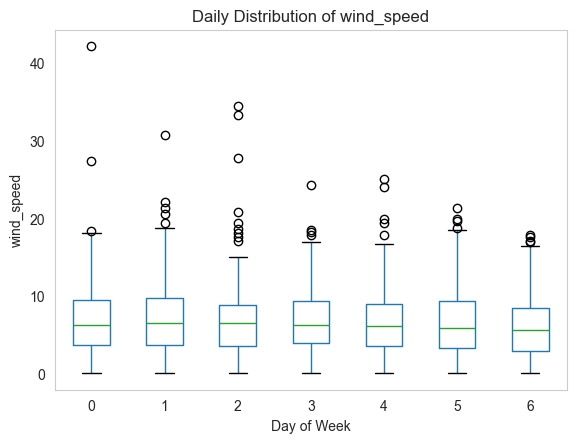

In [26]:
plot_daily_distribution("wind_speed")

### Mean Pressure

<Figure size 2000x1000 with 0 Axes>

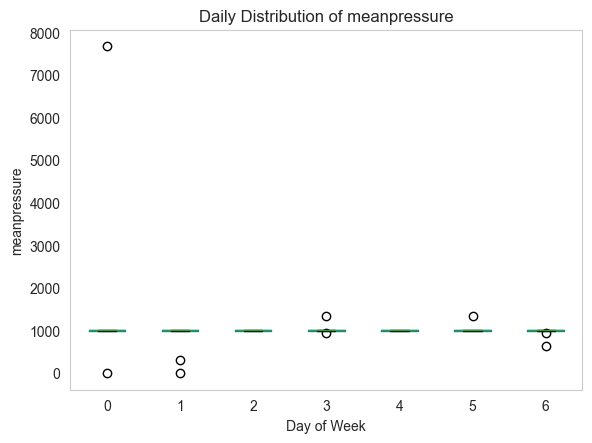

In [27]:
plot_daily_distribution("meanpressure")

## Histogramy

In [28]:
def plot_histogram(feature):
    plt.figure(figsize=(15, 6))
    sns.histplot(df[feature], kde=True, color='purple')
    plt.title(f'{feature} Distribution')
    plt.show()

### Meantemp

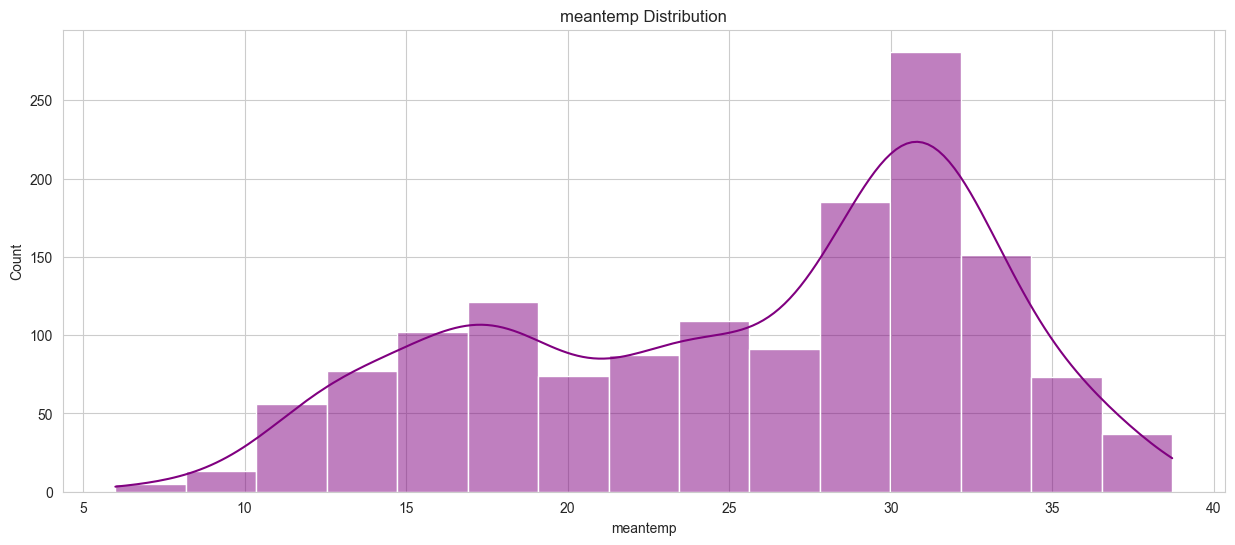

In [29]:
plot_histogram("meantemp")

### Humidity

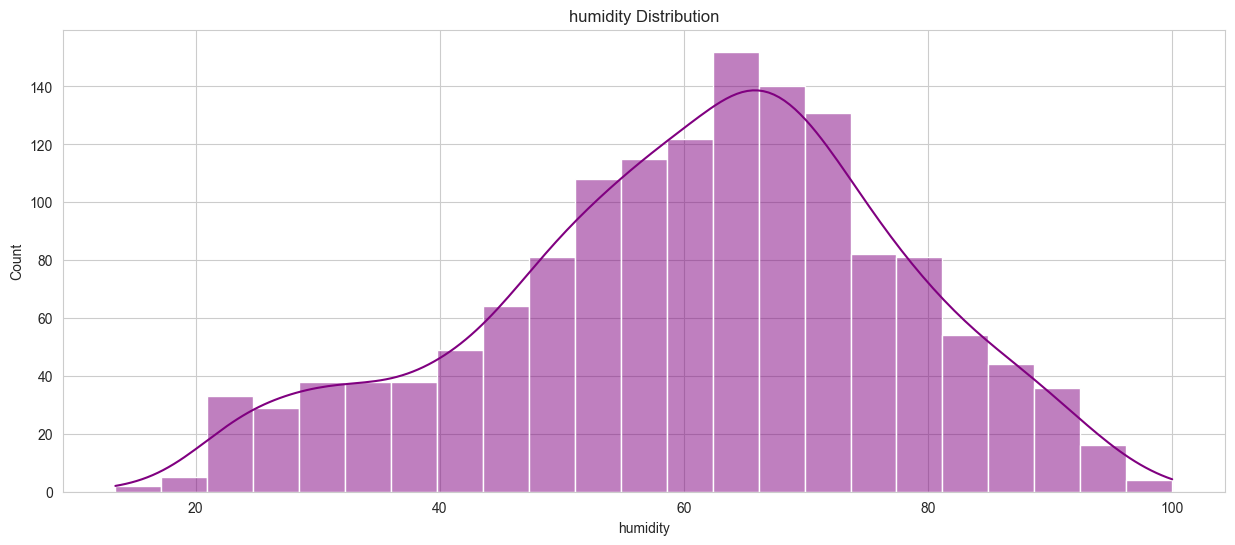

In [30]:
plot_histogram("humidity")

### Wind Speed

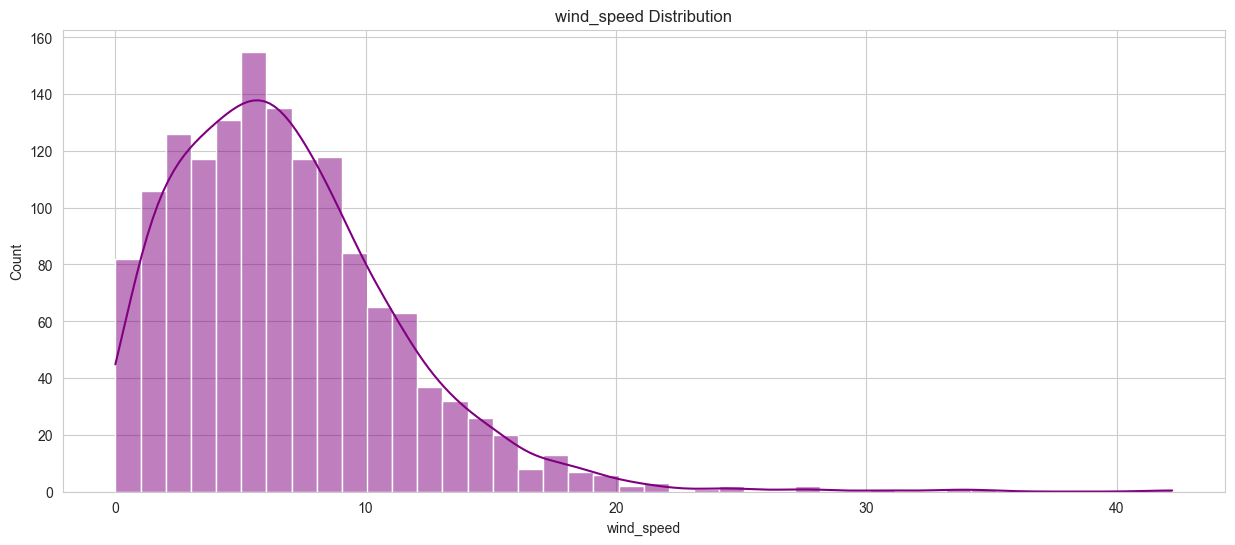

In [31]:
plot_histogram("wind_speed")

### Mean Pressure

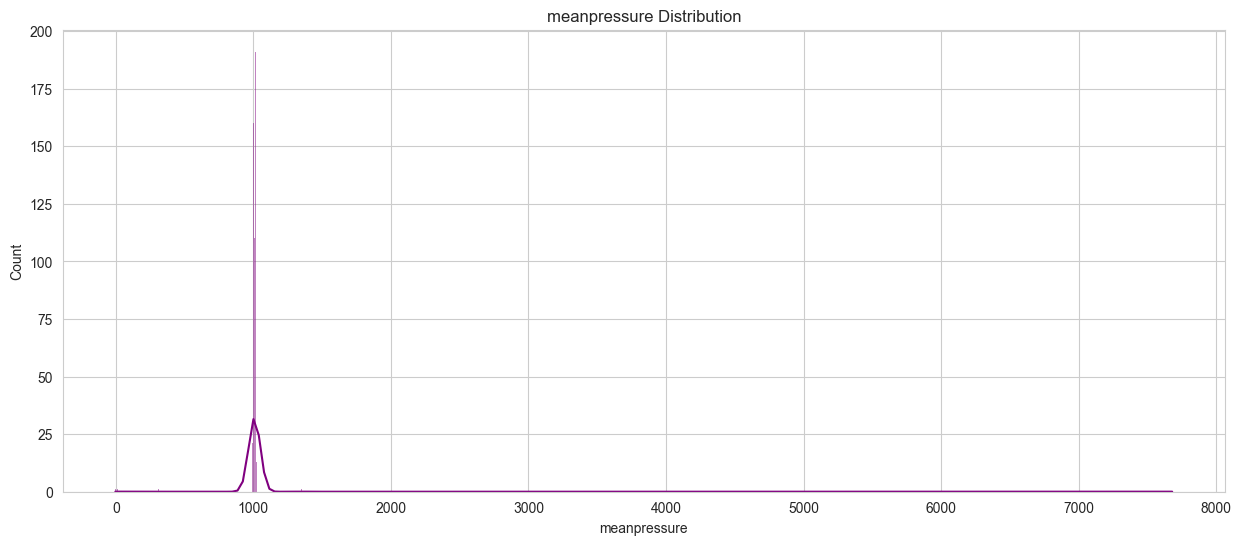

In [32]:
plot_histogram("meanpressure")

# Úprava dat

Ostatn atributy byly odstraněny, protože jsme si je uměle vytvořili za účelem analýzy. Abychome se posunuli dál, musíme se vrátit k původním datům.

In [33]:
df = df[["meantemp", "humidity", "wind_speed"]]
df.head()

,meantemp,humidity,wind_speed
date,,,
2013-01-01,10.000000,84.500000,0.000000
2013-01-02,7.400000,92.000000,2.980000
2013-01-03,7.166667,87.000000,4.633333
2013-01-04,8.666667,71.333333,1.233333
2013-01-05,6.000000,86.833333,3.700000


## Příprava dat

### Trénovací a testovací data

In [34]:
split_ratio = 0.8
split_index = int(split_ratio * len(df))
train_data = df[:split_index]
test_data = df[split_index:]
print(f"Train data shape: {train_data.shape}\nTest data shape: {test_data.shape}")

Train data shape: (1169, 3)
Test data shape: (293, 3)


### Škálování dat

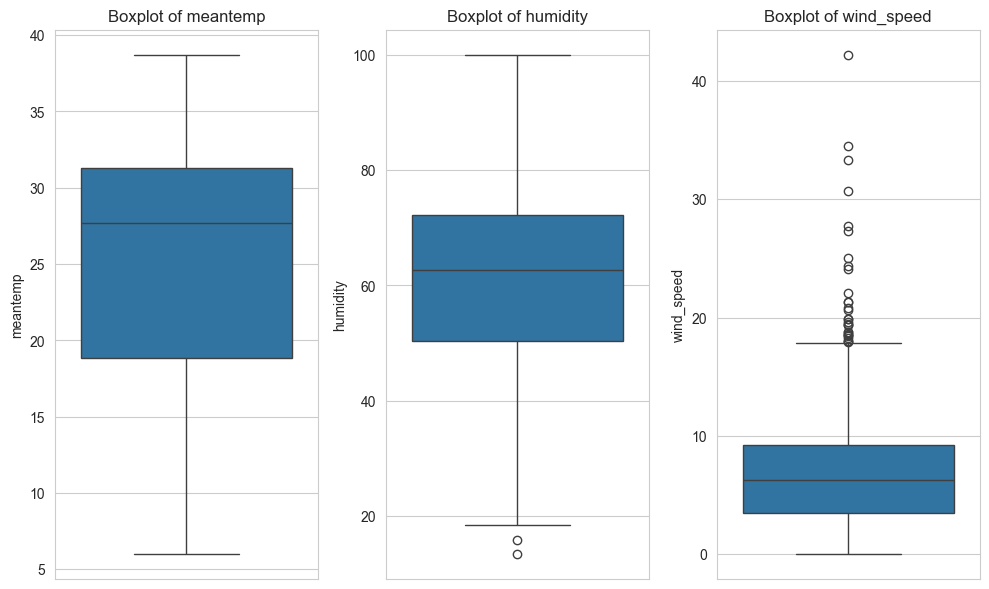

In [35]:
f_columns = ['meantemp', 'humidity', 'wind_speed']
plt.figure(figsize=(10, 6))

plt.subplot(1, 3, 1)
sns.boxplot(y=df['meantemp'])
plt.title('Boxplot of meantemp')

plt.subplot(1, 3, 2)
sns.boxplot(y=df['humidity'])
plt.title('Boxplot of humidity')

plt.subplot(1, 3, 3)
sns.boxplot(y=df['wind_speed'])
plt.title('Boxplot of wind_speed')

plt.tight_layout()
plt.show()

Vidíme, že musíme použít jiné škálování, protože `humidity` a `meantemp` neobsahují žádné odlehlá pozorování, zatímco `wind_speed` obsahuje několik odlehlých pozorování.

Proto škálování provedeme následovně:
- `meantemp` a `humidity` pomocí `MinMax`, jelikož nemusí naléhat normální distribuci
- `wind_speed` pomocí `RobustScaler`, jelikož obsahuje odlehlá pozorování

In [36]:
robust_scaler = RobustScaler()
minmax_scaler = MinMaxScaler()
target_transformer = MinMaxScaler()

In [37]:
train_data['wind_speed'] = robust_scaler.fit_transform(train_data[['wind_speed']])
train_data['humidity'] = minmax_scaler.fit_transform(train_data[['humidity']])
train_data['meantemp'] = target_transformer.fit_transform(train_data[['meantemp']])

test_data['wind_speed'] = robust_scaler.transform(test_data[['wind_speed']])
test_data['humidity'] = minmax_scaler.transform(test_data[['humidity']])
test_data['meantemp'] = target_transformer.transform(test_data[['meantemp']])

In [38]:
display(df.head())
display(train_data.head())

,meantemp,humidity,wind_speed
date,,,
2013-01-01,10.000000,84.500000,0.000000
2013-01-02,7.400000,92.000000,2.980000
2013-01-03,7.166667,87.000000,4.633333
2013-01-04,8.666667,71.333333,1.233333
2013-01-05,6.000000,86.833333,3.700000


,meantemp,humidity,wind_speed
date,,,
2013-01-01,0.122271,0.840372,-1.017818
2013-01-02,0.042795,0.929054,-0.496155
2013-01-03,0.035662,0.869932,-0.206731
2013-01-04,0.081514,0.684685,-0.801917
2013-01-05,0.000000,0.867962,-0.370116


# RNN

In [39]:
def compute_metrics(y_true, y_pred):
    def symetric_mean_absolute_percentage_error(y_true, y_pred):
        return np.mean(np.abs((y_pred - y_true) / ((np.abs(y_true) + np.abs(y_pred)) / 2.0))) * 100

    if isinstance(y_true, torch.Tensor):
        y_true = y_true.cpu().numpy()
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.cpu().numpy()

    metrics = {
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'SMAPE': symetric_mean_absolute_percentage_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    }
    return pd.DataFrame([metrics], index=['metrics'])

In [40]:
def create_dataset(X, Y, time_steps=1):
    Xs, Ys = [], []
    for idx in range(len(X) - time_steps):
        v = X.iloc[idx:(idx + time_steps)].values
        Xs.append(v)
        Ys.append(Y.iloc[idx + time_steps])
    return np.array(Xs), np.array(Ys)

Tato funkce připravuje vstupy a cílové hodnoty pro trénování RNN nebo LSTM. Vytváří sekvence vstupních dat a odpovídajících cílů.

- **X**: Vstupy, obvykle DataFrame s časovými řadami (teplota, vlhkost atd.).
- **y**: Cílové hodnoty k predikci.
- **time_steps**: Délka sekvence, tedy počet minulých bodů pro predikci dalšího.

## Vytvoření sekvencí

In [41]:
TIME_STEPS = 5

`TIME_STEPS` určuje, kolik minulých bodů bude použito pro predikci dalšího bodu.

In [42]:
X_train, Y_train = create_dataset(train_data, train_data.meantemp, TIME_STEPS)
X_test, Y_test = create_dataset(test_data, test_data.meantemp, TIME_STEPS)

Stejně jako předchozí funkce, `create_dataset`, tato funkce vytváří sekvence vstupních dat a odpovídajících cílů, ale tentokrát pro trénovací a testovací data. Data převedeme do **PyTorch** tenzorů, což jsou vícerozměrné pole, které usnadňuje práci s daty.

In [43]:
X_train_tensor = torch.FloatTensor(X_train)
Y_train_tensor = torch.FloatTensor(Y_train)
X_test_tensor = torch.FloatTensor(X_test)
Y_test_tensor = torch.FloatTensor(Y_test)

## Vytvoření modelu

In [44]:
class SimpleRNNModel(nn.Module):
    def __init__(self, input_size, hidden_size=100, num_layers=3, dropout=0.2):
        super(SimpleRNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # output from the last time step
        return out

SimpleRNNModel třída definuje jednoduchou Rekurentní Neuronovou síť (RNN). Jednotlivé části třídy jsou:

- Konstruktor (__init__ metoda):
    - input_size: Počet vstupních atributů.
    - hidden_size: Počet skrytých jednotek (default je 100).
    - num_layers: Počet vrstev (default je 1).
    - dropout: Dropout rate (default je 0.2).
    - self.rnn: RNN vrstva, která mapuje vstupní data na skrytý stav.
    - self.fc: Plně propojená vrstva, která mapuje skrytý stav na výstupní hodnotu.
- Forward Pass (dopředný průchod) - stará se o to, aby tok postupoval správně dopředu:
    - x: Vstupní data.
    - out, _: Výstup z RNN vrstvy.
    - self.fc(out[:, -1, :]): Výstup z plně propojené vrstvy.

In [45]:
input_size = X_train.shape[2]
rnn_model = SimpleRNNModel(input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(rnn_model.parameters())

### Optimalizér

Optimalizér je zodpovědný za optimalizaci modelu. V tomto případě používáme Adam, což je adaptivní optimalizér založený na odhadu prvního a druhého momentu gradientu.

### Ztrátová funkce

Ztrátová funkce je metrika, která měří, jak dobře model predikuje cílové hodnoty. V tomto případě používáme Mean Squared Error (MSE), což je průměrná hodnota rozdílů mezi predikcemi a cílovými hodnotami.

### Parametry pro trénování modelu

In [46]:
num_epochs = 50
batch_size = 16
patience = 10
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

#### Přesun modelu a dat na zařízení

Toto je specifikace *PyTorch* modelu, který říká, aby se model nacházel na zařízení (CPU nebo GPU).

In [47]:
rnn_model = rnn_model.to(device)
criterion = criterion.to(device)

In [48]:
X_train_tensor = X_train_tensor.to(device)
Y_train_tensor = Y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
Y_test_tensor = Y_test_tensor.to(device)

## Trénování modelu

In [49]:
training_loss = np.zeros(num_epochs)
validation_loss = np.zeros(num_epochs)

for epoch in range(num_epochs):
    # Training
    rnn_model.train()
    epoch_train_loss = 0
    for i in range(0, len(X_train_tensor), batch_size):
        inputs = X_train_tensor[i:i + batch_size]
        targets = Y_train_tensor[i:i + batch_size].view(-1, 1)

        optimizer.zero_grad()
        outputs = rnn_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    training_loss[epoch] = epoch_train_loss / len(X_train_tensor)

    # Validation
    rnn_model.eval()
    with torch.no_grad():
        val_outputs = rnn_model(X_test_tensor)
        val_loss = criterion(val_outputs, Y_test_tensor.view(-1, 1))
        validation_loss[epoch] = val_loss.item()

        print(
            f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {training_loss[epoch]:.4f}, Val Loss: {validation_loss[epoch]:.4f}')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = rnn_model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch + 1}')
                break

Epoch 1/50, Training Loss: 0.0048, Val Loss: 0.2457
Epoch 2/50, Training Loss: 0.0033, Val Loss: 0.1132
Epoch 3/50, Training Loss: 0.0019, Val Loss: 0.0580
Epoch 4/50, Training Loss: 0.0016, Val Loss: 0.0302
Epoch 5/50, Training Loss: 0.0010, Val Loss: 0.0085
Epoch 6/50, Training Loss: 0.0005, Val Loss: 0.0049
Epoch 7/50, Training Loss: 0.0004, Val Loss: 0.0182
Epoch 8/50, Training Loss: 0.0005, Val Loss: 0.0069
Epoch 9/50, Training Loss: 0.0004, Val Loss: 0.0218
Epoch 10/50, Training Loss: 0.0006, Val Loss: 0.0136
Epoch 11/50, Training Loss: 0.0005, Val Loss: 0.0096
Epoch 12/50, Training Loss: 0.0004, Val Loss: 0.0156
Epoch 13/50, Training Loss: 0.0005, Val Loss: 0.0163
Epoch 14/50, Training Loss: 0.0004, Val Loss: 0.0109
Epoch 15/50, Training Loss: 0.0005, Val Loss: 0.0336
Epoch 16/50, Training Loss: 0.0006, Val Loss: 0.0070
Early stopping at epoch 16


#### Získání nejlepšího modelu

In [50]:
if best_model_state is not None:
    rnn_model.load_state_dict(best_model_state)

#### Vyhodnocení modelu

In [51]:
rnn_model.eval()
with torch.no_grad():
    test_predictions = rnn_model(X_test_tensor)
    test_loss = criterion(test_predictions, Y_test_tensor.view(-1, 1))
    print(f'Final Validation Loss: {test_loss.item():.4f}')

Final Validation Loss: 0.0070


In [52]:
rnn_metrics = compute_metrics(Y_test_tensor, test_predictions)
rnn_metrics

,MAE,MSE,RMSE,SMAPE,R2
metrics,0.066681,0.006951,0.083372,29.132261,0.769634


In [53]:
torchsummary.summary(rnn_model, input_size=(X_train_tensor.shape[1], X_train_tensor.shape[2]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               RNN-1  [[-1, 5, 100], [-1, 2, 100]]               0
            Linear-2                    [-1, 1]             101
Total params: 101
Trainable params: 101
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.76
Params size (MB): 0.00
Estimated Total Size (MB): 0.76
----------------------------------------------------------------


## Vizualizace predikcí

### Vizualizace predikcí opravdových hodnot

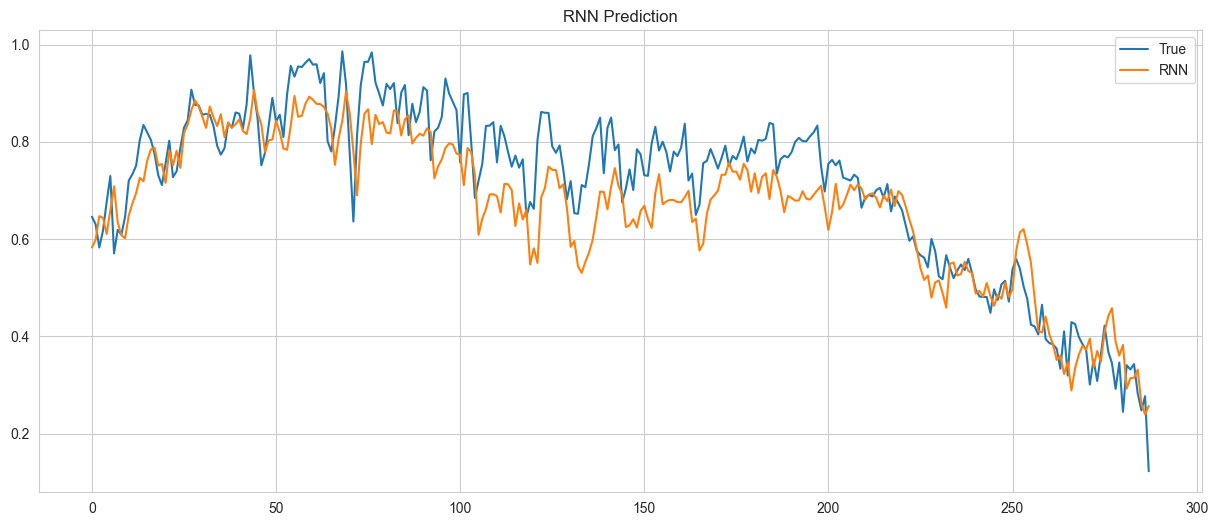

In [54]:
plt.figure(figsize=(15, 6))
plt.plot(Y_test_tensor.cpu().numpy(), label='True')
plt.plot(test_predictions.cpu().numpy(), label='RNN')
plt.title('RNN Prediction')
plt.legend()
plt.show()

### Ztrátová funkce

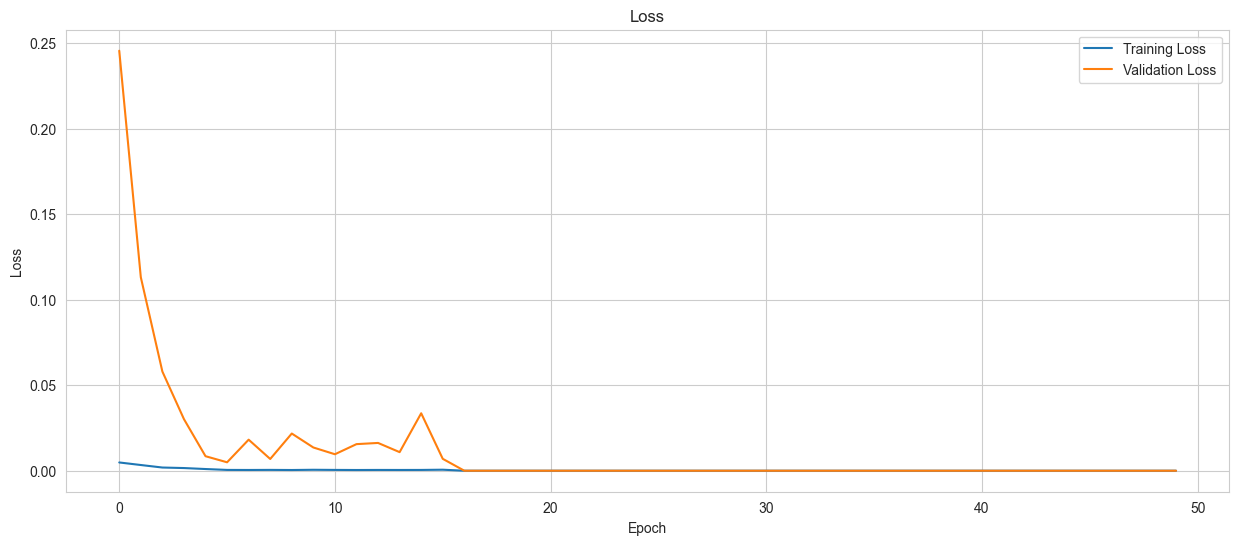

In [55]:
fig = plt.figure(figsize=(15, 6))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Různé parametry

Zadejme různé parametry pro model a vybereme nejlepší kombinaci a pro naší zvědavost zjistíme, jak se model chová s různými parametry.

In [56]:
sequence_lengths = [5, 10, 20]
hidden_sizes = [50, 100, 200]
num_epochs = 50
batch_size = 16
patience = 10

results = []

for seq_len in sequence_lengths:
    for hidden_size in hidden_sizes:
        print(f"Running with sequence length: {seq_len}, hidden size: {hidden_size}")

        # we need to recreate the dataset with the new sequence length, convert to tensors and move to device
        X_train, Y_train = create_dataset(train_data, train_data.meantemp, seq_len)
        X_test, Y_test = create_dataset(test_data, test_data.meantemp, seq_len)

        X_train_tensor = torch.FloatTensor(X_train).to(device)
        Y_train_tensor = torch.FloatTensor(Y_train).to(device)
        X_test_tensor = torch.FloatTensor(X_test).to(device)
        Y_test_tensor = torch.FloatTensor(Y_test).to(device)

        input_size = X_train.shape[2]
        rnn_model = SimpleRNNModel(input_size, hidden_size, num_layers=3, dropout=0.2).to(device)
        criterion = nn.MSELoss().to(device)
        optimizer = optim.Adam(rnn_model.parameters())

        # Training loop
        training_loss = np.zeros(num_epochs)
        validation_loss = np.zeros(num_epochs)
        rmse_scores = np.zeros(num_epochs)
        r2_scores = np.zeros(num_epochs)
        best_val_loss = float('inf')
        patience_counter = 0
        best_model_state = None

        for epoch in range(num_epochs):
            # Training
            rnn_model.train()
            epoch_train_loss = 0
            for i in range(0, len(X_train_tensor), batch_size):
                inputs = X_train_tensor[i:i + batch_size]
                targets = Y_train_tensor[i:i + batch_size].view(-1, 1)

                optimizer.zero_grad()
                outputs = rnn_model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

                epoch_train_loss += loss.item()

            training_loss[epoch] = epoch_train_loss / len(X_train_tensor)

            # Validation
            rnn_model.eval()
            with torch.no_grad():
                val_outputs = rnn_model(X_test_tensor)
                val_loss = criterion(val_outputs, Y_test_tensor.view(-1, 1))
                validation_loss[epoch] = val_loss.item()

                rmse = torch.sqrt(val_loss).item()
                r2_score_val = 1 - (val_loss / Y_test_tensor.var()).item()
                rmse_scores[epoch] = rmse
                r2_scores[epoch] = r2_score_val

                print(
                    f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {training_loss[epoch]:.4f}, Val Loss: {validation_loss[epoch]:.4f}, RMSE: {rmse:.4f}, R2 Score: {r2_score_val:.4f}')

                # Early stopping
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model_state = rnn_model.state_dict().copy()
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        print(f'Early stopping at epoch {epoch + 1}')
                        break

        # Restore best model
        if best_model_state is not None:
            rnn_model.load_state_dict(best_model_state)

        # Evaluate on test set
        rnn_model.eval()
        with torch.no_grad():
            test_predictions = rnn_model(X_test_tensor)
            test_loss = criterion(test_predictions, Y_test_tensor.view(-1, 1))
            rmse_rnn = torch.sqrt(test_loss).item()
            r2_score_rnn = 1 - (test_loss / Y_test_tensor.var()).item()
            print(f"Final Validation Loss: {test_loss.item():.4f}")
            print(f"RMSE: {rmse_rnn:.4f}\nR2 Score: {r2_score_rnn:.4f}")

        results.append({
            'sequence_length': seq_len,
            'hidden_size': hidden_size,
            'training_loss': training_loss,
            'validation_loss': validation_loss,
            'rmse': rmse_rnn,
            'r2_score': r2_score_rnn
        })

Running with sequence length: 5, hidden size: 50
Epoch 1/50, Training Loss: 0.0048, Val Loss: 0.0242, RMSE: 0.1557, R2 Score: 0.1991
Epoch 2/50, Training Loss: 0.0031, Val Loss: 0.0103, RMSE: 0.1015, R2 Score: 0.6599
Epoch 3/50, Training Loss: 0.0009, Val Loss: 0.0049, RMSE: 0.0702, R2 Score: 0.8371
Epoch 4/50, Training Loss: 0.0004, Val Loss: 0.0079, RMSE: 0.0890, R2 Score: 0.7386
Epoch 5/50, Training Loss: 0.0004, Val Loss: 0.0136, RMSE: 0.1165, R2 Score: 0.5515
Epoch 6/50, Training Loss: 0.0006, Val Loss: 0.0200, RMSE: 0.1415, R2 Score: 0.3388
Epoch 7/50, Training Loss: 0.0006, Val Loss: 0.0104, RMSE: 0.1022, R2 Score: 0.6552
Epoch 8/50, Training Loss: 0.0004, Val Loss: 0.0067, RMSE: 0.0820, R2 Score: 0.7780
Epoch 9/50, Training Loss: 0.0004, Val Loss: 0.0101, RMSE: 0.1007, R2 Score: 0.6650
Epoch 10/50, Training Loss: 0.0004, Val Loss: 0.0115, RMSE: 0.1071, R2 Score: 0.6213
Epoch 11/50, Training Loss: 0.0004, Val Loss: 0.0106, RMSE: 0.1031, R2 Score: 0.6488
Epoch 12/50, Training Los

In [57]:
best_result = min(results, key=lambda x: x['rmse'])
print(
    f"Best Sequence Length: {best_result['sequence_length']}, "
    f"Best Hidden Size: {best_result['hidden_size']}\n"
    f"R2 Score: {best_result['r2_score']:.4f}\n"
    f"RMSE: {best_result['rmse']:.4f}"
)

Best Sequence Length: 5, Best Hidden Size: 200
R2 Score: 0.7656
RMSE: 0.0842


# LSTM

LSTM (Long Short-Term Memory) modely jsou typem rekurentních neuronových sítí (RNN) navržených pro zachycení dlouhodobých závislostí v sekvenčních datech. Jsou účinné pro úlohy zahrnující predikci časových řad, zpracování přirozeného jazyka a další problémy založené na sekvencích.

In [58]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=100, num_layers=3, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

## Vše probíhá stejně jako u RNN, jen s tím rozdílem, že používáme LSTM místo RNN.

In [59]:
input_size = X_train.shape[2]
lstm_model = LSTMModel(input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters())

In [60]:
num_epochs = 50
batch_size = 16
patience = 10
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

In [61]:
lstm_model = lstm_model.to(device)
criterion = criterion.to(device)

In [62]:
X_train_tensor = X_train_tensor.to(device)
Y_train_tensor = Y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
Y_test_tensor = Y_test_tensor.to(device)

In [63]:
training_loss = np.zeros(num_epochs)
validation_loss = np.zeros(num_epochs)

for epoch in range(num_epochs):
    # Training
    lstm_model.train()
    epoch_train_loss = 0
    for i in range(0, len(X_train_tensor), batch_size):
        inputs = X_train_tensor[i:i + batch_size]
        targets = Y_train_tensor[i:i + batch_size].view(-1, 1)

        optimizer.zero_grad()
        outputs = lstm_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    training_loss[epoch] = epoch_train_loss / len(X_train_tensor)

    # Validation
    lstm_model.eval()
    with torch.no_grad():
        val_outputs = lstm_model(X_test_tensor)
        val_loss = criterion(val_outputs, Y_test_tensor.view(-1, 1))
        validation_loss[epoch] = val_loss.item()

        print(
            f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {training_loss[epoch]:.4f}, Val Loss: {validation_loss[epoch]:.4f}')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = lstm_model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch + 1}')
                break

Epoch 1/50, Training Loss: 0.0059, Val Loss: 0.0196
Epoch 2/50, Training Loss: 0.0025, Val Loss: 0.0805
Epoch 3/50, Training Loss: 0.0014, Val Loss: 0.0123
Epoch 4/50, Training Loss: 0.0006, Val Loss: 0.0134
Epoch 5/50, Training Loss: 0.0005, Val Loss: 0.0152
Epoch 6/50, Training Loss: 0.0005, Val Loss: 0.0114
Epoch 7/50, Training Loss: 0.0004, Val Loss: 0.0106
Epoch 8/50, Training Loss: 0.0004, Val Loss: 0.0109
Epoch 9/50, Training Loss: 0.0004, Val Loss: 0.0122
Epoch 10/50, Training Loss: 0.0005, Val Loss: 0.0142
Epoch 11/50, Training Loss: 0.0005, Val Loss: 0.0171
Epoch 12/50, Training Loss: 0.0004, Val Loss: 0.0123
Epoch 13/50, Training Loss: 0.0004, Val Loss: 0.0121
Epoch 14/50, Training Loss: 0.0004, Val Loss: 0.0124
Epoch 15/50, Training Loss: 0.0004, Val Loss: 0.0107
Epoch 16/50, Training Loss: 0.0004, Val Loss: 0.0192
Epoch 17/50, Training Loss: 0.0004, Val Loss: 0.0142
Early stopping at epoch 17


In [64]:
if best_model_state is not None:
    lstm_model.load_state_dict(best_model_state)

In [65]:
lstm_model.eval()
with torch.no_grad():
    test_predictions = lstm_model(X_test_tensor)
    test_loss = criterion(test_predictions, Y_test_tensor.view(-1, 1))
    print(f'Final Validation Loss: {test_loss.item():.4f}')

Final Validation Loss: 0.0142


In [66]:
lstm_metrics = compute_metrics(Y_test_tensor, test_predictions)
print(lstm_metrics)

              MAE      MSE      RMSE      SMAPE        R2
metrics  0.101267  0.01419  0.119121  29.526243  0.548566


In [67]:
# TODO: summary of the model

## Vizualizace predikcí

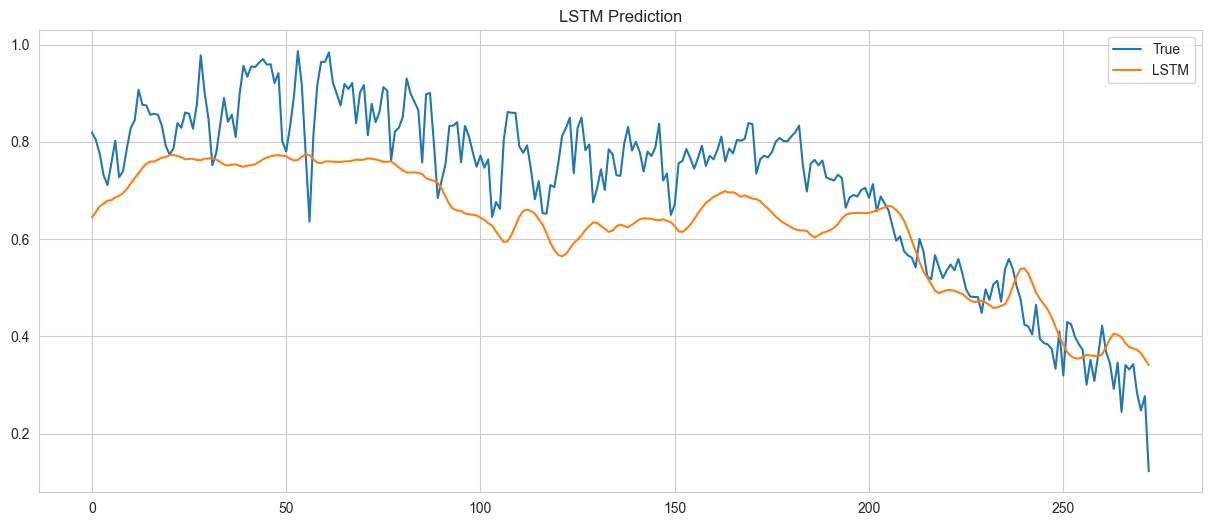

In [68]:
plt.figure(figsize=(15, 6))
plt.plot(Y_test_tensor.cpu().numpy(), label='True')
plt.plot(test_predictions.cpu().numpy(), label='LSTM')
plt.title('LSTM Prediction')
plt.legend()
plt.show()

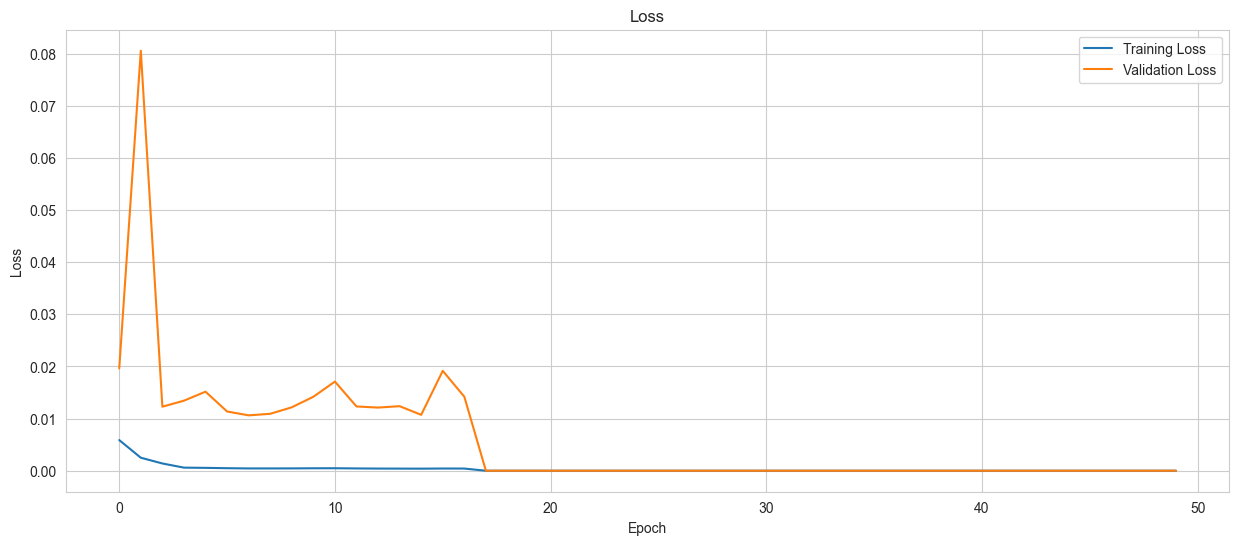

In [69]:
fig = plt.figure(figsize=(15, 6))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Bidirectional LSTM

Bidirectional LSTM je typ LSTM modelu, který zpracovává sekvenční data ve dvou směrech, což umožňuje lepší zachycení kontextu a závislostí v datech. Tento model má dvě LSTM vrstvy, jednu pro zpracování dat v předním směru a druhou pro zpracování dat v opačném směru. Výstupy z obou směrů jsou poté kombinovány.

In [70]:
class BidirectionalLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=100, num_layers=3, dropout=0.2):
        super(BidirectionalLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Take the output from the last time step
        return out

## Opět stejný postup...

In [71]:
input_size = X_train.shape[2]
bidirectional_lstm_model = BidirectionalLSTMModel(input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(bidirectional_lstm_model.parameters())

In [72]:
num_epochs = 50
batch_size = 16
patience = 10
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

In [73]:
bidirectional_lstm_model = bidirectional_lstm_model.to(device)
criterion = criterion.to(device)

In [74]:
X_train_tensor = X_train_tensor.to(device)
Y_train_tensor = Y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
Y_test_tensor = Y_test_tensor.to(device)

In [75]:
training_loss = np.zeros(num_epochs)
validation_loss = np.zeros(num_epochs)

for epoch in range(num_epochs):
    # Training
    bidirectional_lstm_model.train()
    epoch_train_loss = 0
    for i in range(0, len(X_train_tensor), batch_size):
        inputs = X_train_tensor[i:i + batch_size]
        targets = Y_train_tensor[i:i + batch_size].view(-1, 1)

        optimizer.zero_grad()
        outputs = bidirectional_lstm_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    training_loss[epoch] = epoch_train_loss / len(X_train_tensor)

    # Validation
    bidirectional_lstm_model.eval()
    with torch.no_grad():
        val_outputs = bidirectional_lstm_model(X_test_tensor)
        val_loss = criterion(val_outputs, Y_test_tensor.view(-1, 1))
        validation_loss[epoch] = val_loss.item()

        print(
            f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {training_loss[epoch]:.4f}, Val Loss: {validation_loss[epoch]:.4f}')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = bidirectional_lstm_model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch + 1}')
                break

Epoch 1/50, Training Loss: 0.0051, Val Loss: 0.0218
Epoch 2/50, Training Loss: 0.0027, Val Loss: 0.0178
Epoch 3/50, Training Loss: 0.0009, Val Loss: 0.0108
Epoch 4/50, Training Loss: 0.0006, Val Loss: 0.0188
Epoch 5/50, Training Loss: 0.0004, Val Loss: 0.0101
Epoch 6/50, Training Loss: 0.0003, Val Loss: 0.0082
Epoch 7/50, Training Loss: 0.0002, Val Loss: 0.0047
Epoch 8/50, Training Loss: 0.0002, Val Loss: 0.0045
Epoch 9/50, Training Loss: 0.0002, Val Loss: 0.0054
Epoch 10/50, Training Loss: 0.0002, Val Loss: 0.0043
Epoch 11/50, Training Loss: 0.0002, Val Loss: 0.0087
Epoch 12/50, Training Loss: 0.0002, Val Loss: 0.0091
Epoch 13/50, Training Loss: 0.0003, Val Loss: 0.0051
Epoch 14/50, Training Loss: 0.0003, Val Loss: 0.0055
Epoch 15/50, Training Loss: 0.0002, Val Loss: 0.0189
Epoch 16/50, Training Loss: 0.0004, Val Loss: 0.0126
Epoch 17/50, Training Loss: 0.0004, Val Loss: 0.0065
Epoch 18/50, Training Loss: 0.0006, Val Loss: 0.0143
Epoch 19/50, Training Loss: 0.0003, Val Loss: 0.0253
Ep

In [76]:
if best_model_state is not None:
    bidirectional_lstm_model.load_state_dict(best_model_state)

In [77]:
bidirectional_lstm_model.eval()
with torch.no_grad():
    test_predictions = bidirectional_lstm_model(X_test_tensor)
    test_loss = criterion(test_predictions, Y_test_tensor.view(-1, 1))
    print(f'Final Validation Loss: {test_loss.item():.4f}')

Final Validation Loss: 0.0034


In [78]:
rmse_bidirectional_lstm = torch.sqrt(test_loss).item()
r2_score_bidirectional_lstm = 1 - (test_loss / Y_test_tensor.var()).item()
print(f"RMSE: {rmse_bidirectional_lstm:.4f}\nR2 Score: {r2_score_bidirectional_lstm:.4f}")

RMSE: 0.0580
R2 Score: 0.8932


In [79]:
# TODO: summary of the model

## Vizualizace predikcí

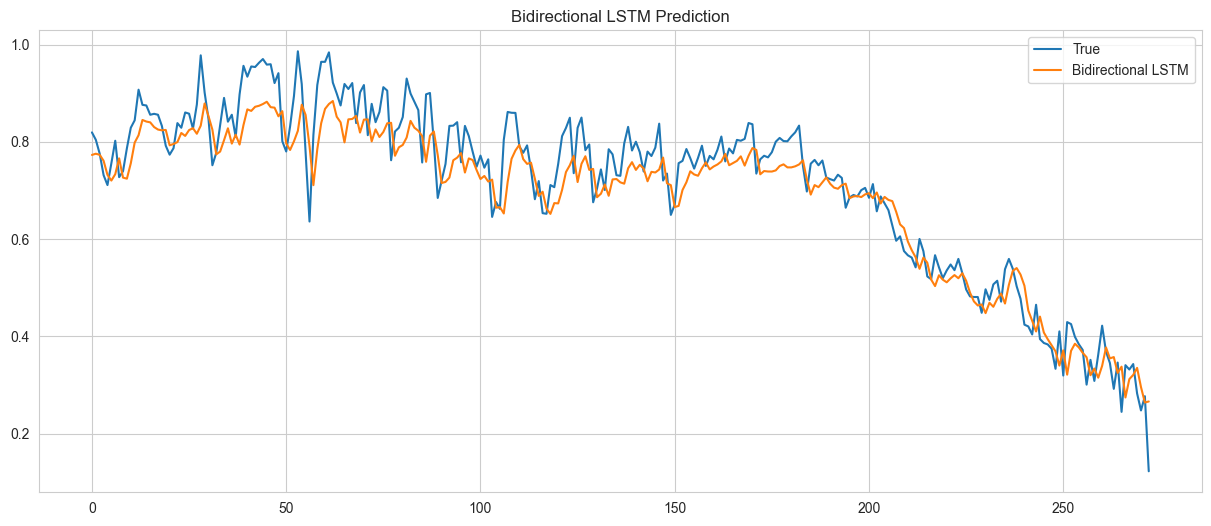

In [80]:
plt.figure(figsize=(15, 6))
plt.plot(Y_test_tensor.cpu().numpy(), label='True')
plt.plot(test_predictions.cpu().numpy(), label='Bidirectional LSTM')
plt.title('Bidirectional LSTM Prediction')
plt.legend()
plt.show()

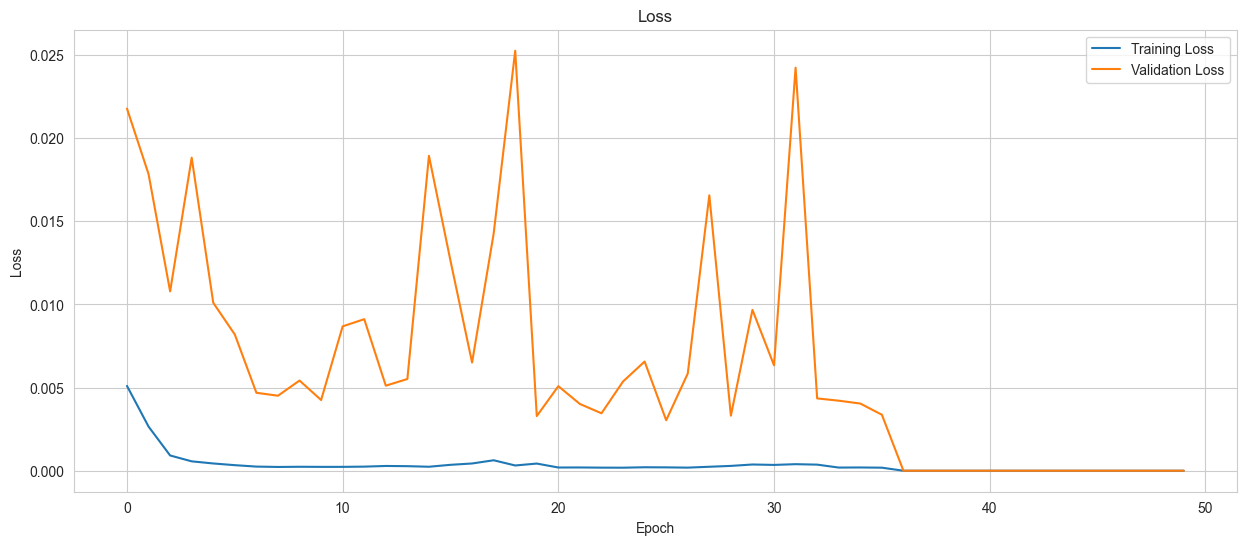

In [81]:
fig = plt.figure(figsize=(15, 6))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [82]:
bi_dir_lstm_metrics = compute_metrics(test_predictions, Y_test_tensor)
bi_dir_lstm_metrics

,MAE,MSE,RMSE,SMAPE,R2
metrics,0.046868,0.003368,0.058036,28.760567,0.860821


# GRU

In [83]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size=100, num_layers=3, dropout=0.2):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out

GRU (Gated Recurrent Unit) modely jsou typem rekurentních neuronových sítí (RNN), které jsou navrženy pro efektivní zpracování sekvenčních dat. GRU modely jsou podobné LSTM modelům, ale mají jednodušší architekturu, což vede k rychlejšímu trénování a menší paměťové náročnosti. GRU modely používají dvě brány k řízení toku informací a udržení dlouhodobých závislostí v datech.

## Do třetice všeho dobrého...

In [84]:
input_size = X_train.shape[2]
gru_model = GRUModel(input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(gru_model.parameters())

In [85]:
num_epochs = 50
batch_size = 16
patience = 10
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

In [86]:
gru_model = gru_model.to(device)
criterion = criterion.to(device)

In [87]:
X_train_tensor = X_train_tensor.to(device)
Y_train_tensor = Y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
Y_test_tensor = Y_test_tensor.to(device)

In [88]:
training_loss = np.zeros(num_epochs)
validation_loss = np.zeros(num_epochs)

for epoch in range(num_epochs):
    # Training
    gru_model.train()
    epoch_train_loss = 0
    for i in range(0, len(X_train_tensor), batch_size):
        inputs = X_train_tensor[i:i + batch_size]
        targets = Y_train_tensor[i:i + batch_size].view(-1, 1)

        optimizer.zero_grad()
        outputs = gru_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    training_loss[epoch] = epoch_train_loss / len(X_train_tensor)

    # Validation
    gru_model.eval()
    with torch.no_grad():
        val_outputs = gru_model(X_test_tensor)
        val_loss = criterion(val_outputs, Y_test_tensor.view(-1, 1))
        validation_loss[epoch] = val_loss.item()

        print(
            f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {training_loss[epoch]:.4f}, Val Loss: {validation_loss[epoch]:.4f}')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = gru_model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch + 1}')
                break

Epoch 1/50, Training Loss: 0.0048, Val Loss: 0.0534
Epoch 2/50, Training Loss: 0.0022, Val Loss: 0.0532
Epoch 3/50, Training Loss: 0.0009, Val Loss: 0.0108
Epoch 4/50, Training Loss: 0.0004, Val Loss: 0.0065
Epoch 5/50, Training Loss: 0.0004, Val Loss: 0.0070
Epoch 6/50, Training Loss: 0.0004, Val Loss: 0.0110
Epoch 7/50, Training Loss: 0.0004, Val Loss: 0.0152
Epoch 8/50, Training Loss: 0.0004, Val Loss: 0.0088
Epoch 9/50, Training Loss: 0.0004, Val Loss: 0.0108
Epoch 10/50, Training Loss: 0.0004, Val Loss: 0.0088
Epoch 11/50, Training Loss: 0.0003, Val Loss: 0.0116
Epoch 12/50, Training Loss: 0.0003, Val Loss: 0.0105
Epoch 13/50, Training Loss: 0.0003, Val Loss: 0.0104
Epoch 14/50, Training Loss: 0.0003, Val Loss: 0.0125
Early stopping at epoch 14


In [89]:
if best_model_state is not None:
    gru_model.load_state_dict(best_model_state)

In [90]:
gru_model.eval()
with torch.no_grad():
    test_predictions = gru_model(X_test_tensor)
    test_loss = criterion(test_predictions, Y_test_tensor.view(-1, 1))
    print(f'Final Validation Loss: {test_loss.item():.4f}')

Final Validation Loss: 0.0125


In [91]:
gru_metrics = compute_metrics(test_predictions, Y_test_tensor)
gru_metrics

,MAE,MSE,RMSE,SMAPE,R2
metrics,0.096066,0.012538,0.111972,30.006313,0.211214


In [92]:
# TODO: summary of the model

## Vizualizace predikcí

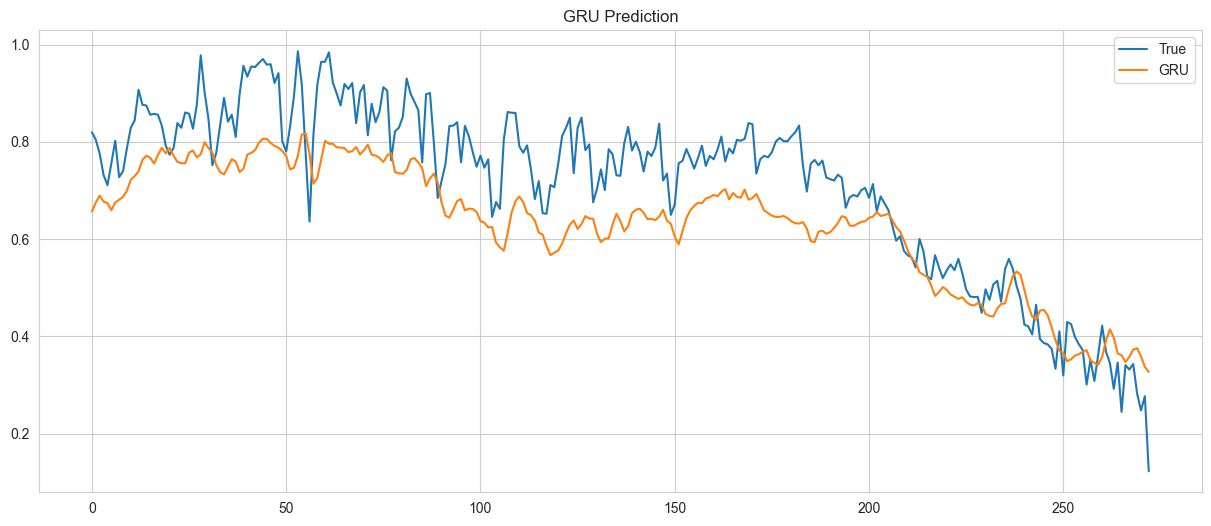

In [93]:
plt.figure(figsize=(15, 6))
plt.plot(Y_test_tensor.cpu().numpy(), label='True')
plt.plot(test_predictions.cpu().numpy(), label='GRU')
plt.title('GRU Prediction')
plt.legend()
plt.show()

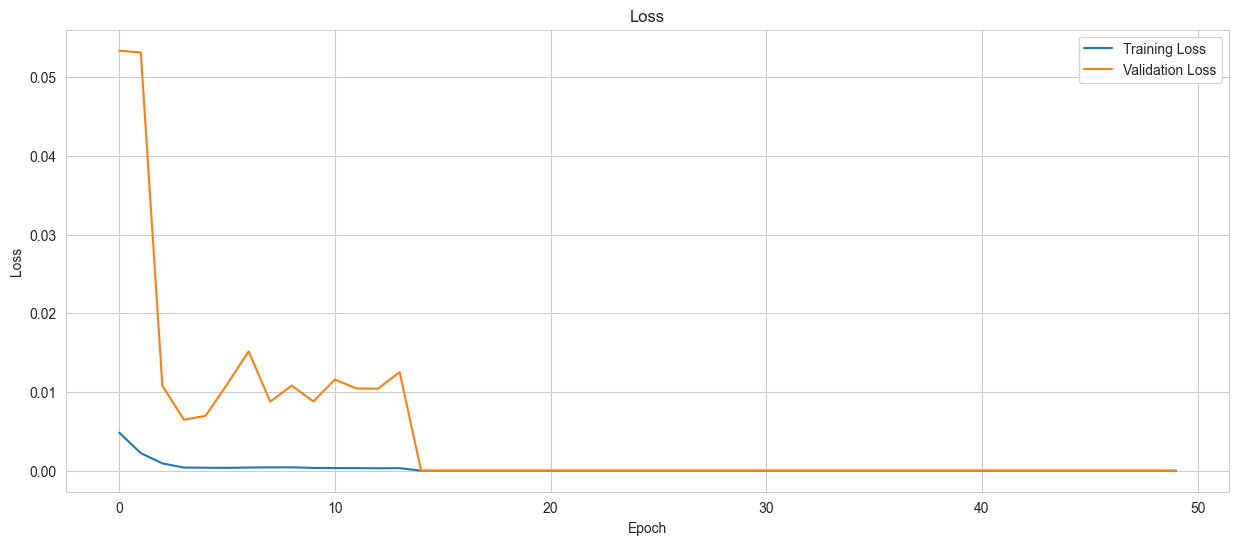

In [94]:
fig = plt.figure(figsize=(15, 6))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Porovnání všech modelů

In [95]:
metrics_list = [rnn_metrics, lstm_metrics, bi_dir_lstm_metrics, gru_metrics]
model_name_list = ["RNN", "LSTM", "Bidirectional LSTM", "GRU"]

for df, name in zip(metrics_list, model_name_list):
    df['Model'] = name

merged_df = pd.concat(metrics_list, ignore_index=True)
merged_df

,MAE,MSE,RMSE,SMAPE,R2,Model
0,0.066681,0.006951,0.083372,29.132261,0.769634,RNN
1,0.101267,0.014190,0.119121,29.526243,0.548566,LSTM
2,0.046868,0.003368,0.058036,28.760567,0.860821,Bidirectional LSTM
3,0.096066,0.012538,0.111972,30.006313,0.211214,GRU
